<a href="https://colab.research.google.com/github/Pablobm3/Detector-de-Balsas/blob/main/pruebaRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from PIL import Image
import numpy as np

def crear_mascara(imagen_path, umbral_color, salida_path):
    """
    Crea una máscara binaria a partir de una imagen satelital filtrada por color.

    Args:
        imagen_path (str): Ruta de la imagen original.
        umbral_color (tuple): Valores RGB para identificar balsas (mín, máx).
        salida_path (str): Ruta para guardar la máscara generada.
    """
    # Cargar imagen
    imagen = np.array(Image.open(imagen_path))

    # Crear una máscara binaria para colores en el rango
    minima, maxima = umbral_color
    mascara = np.all((imagen >= minima) & (imagen <= maxima), axis=-1)

    # Guardar la máscara como imagen binaria (0 o 255)
    mascara = (mascara * 255).astype(np.uint8)
    Image.fromarray(mascara).save(salida_path)

# Crear máscaras para tus imágenes
umbral_color_balsa = ((17, 9, 27), (47, 12, 101))  # Ajusta estos valores según el azul marino
ruta_imagenes = "/content/data/"
nombres_imagenes = [f"Balsa{i}.jpg" for i in range(1, 26)]

for nombre in nombres_imagenes:
    crear_mascara(ruta_imagenes + nombre, umbral_color_balsa, ruta_imagenes + "Mascaras/" + nombre.split('.')[0] + "_mask.jpg")



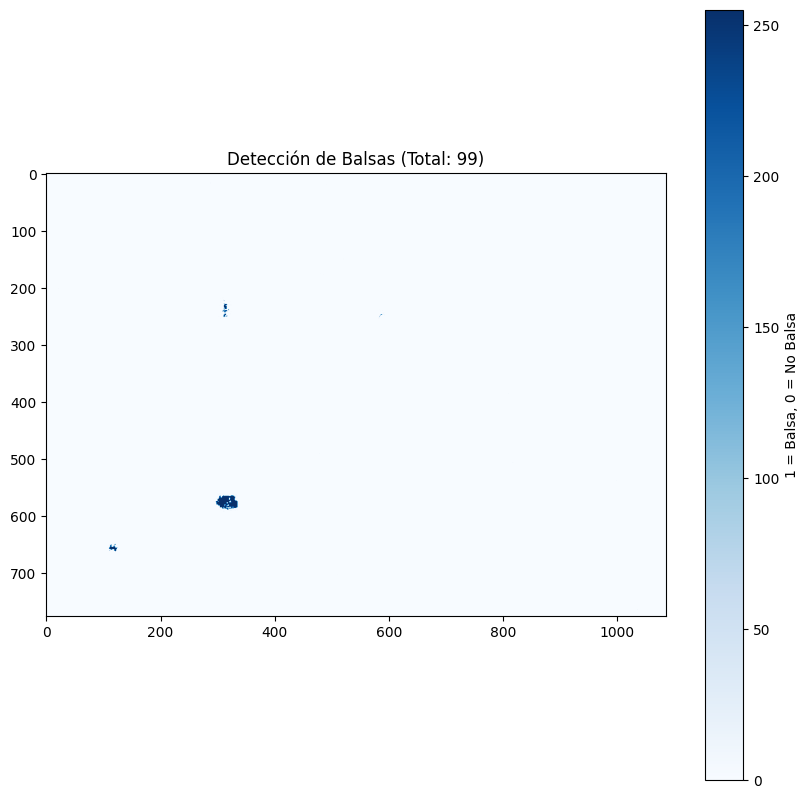

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.ndimage import label
from PIL import Image

# Variables importantes
directorio_imagenes = "/content/data/"  # Cambia por la ruta a tus imágenes
nombres_imagenes = [f"Balsa{i}.jpg" for i in range(1, 26)]  # Nombres de tus imágenes
mascaras = [f"/Mascaras/Balsa{i}_mask.jpg" for i in range(1, 26)]  # Máscaras de entrenamiento

# Función para cargar imágenes y generar datos de entrenamiento
def cargar_datos(directorio, nombres, mascaras):
    pixeles = []
    etiquetas = []

    for imagen, mascara in zip(nombres, mascaras):
        # Cargar imagen y máscara
        img = np.array(Image.open(directorio + imagen)) / 255.0
        mask = np.array(Image.open(directorio + mascara))

        # Transformar en vectores
        pixeles.extend(img.reshape(-1, 3))  # RGB
        etiquetas.extend(mask.flatten())   # Etiquetas binarias (0 o 1)

    return np.array(pixeles), np.array(etiquetas)

# Cargar datos de entrenamiento
pixeles, etiquetas = cargar_datos(directorio_imagenes, nombres_imagenes, mascaras)

# Dividir en conjunto de entrenamiento y prueba
pixeles_entrenamiento, pixeles_test, etiquetas_entrenamiento, etiquetas_test = train_test_split(
    pixeles, etiquetas, test_size=0.2, random_state=42
)

# Normalización de datos
scaler = StandardScaler()
pixeles_entrenamiento = scaler.fit_transform(pixeles_entrenamiento)
pixeles_test = scaler.transform(pixeles_test)

# Entrenamiento del modelo (Random Forest)
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(pixeles_entrenamiento, etiquetas_entrenamiento)




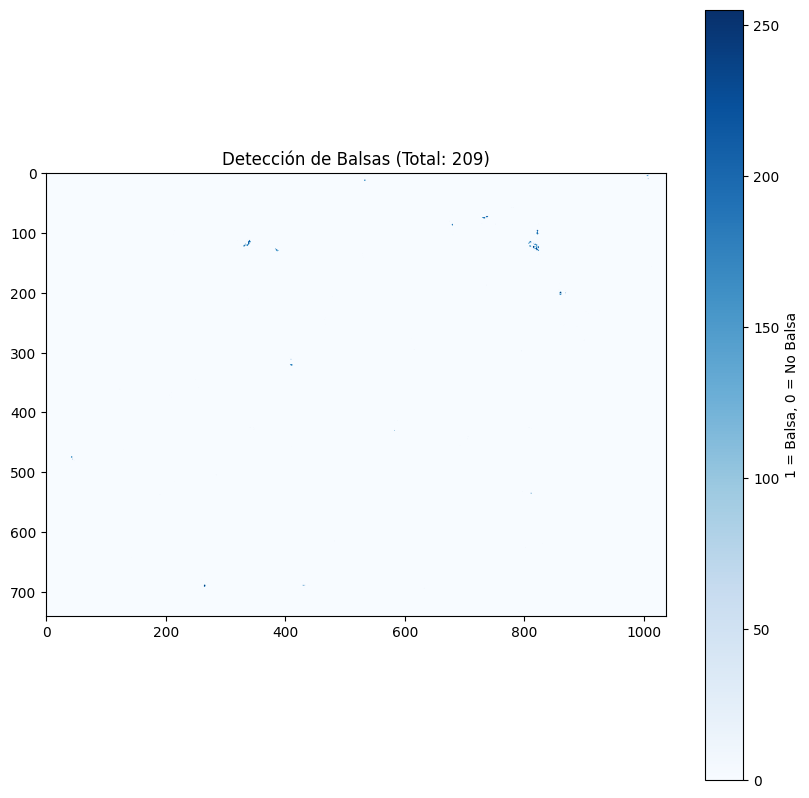

In [9]:
# Función para clasificar una nueva imagen
def clasificar_imagen(directorio, nombre_imagen, modelo, scaler):
    # Cargar imagen y preprocesar
    img = np.array(Image.open(directorio + nombre_imagen)) / 255.0
    pixeles = img.reshape(-1, 3)
    pixeles_normalizados = scaler.transform(pixeles)

    # Predicción de la clasificación
    predicciones = modelo.predict(pixeles_normalizados)
    return predicciones.reshape(img.shape[0], img.shape[1])

# Clasificar una imagen de prueba
nombre_imagen_prueba = "Balsa26.jpg"  # Cambia por la imagen que quieres clasificar
clasificacion = clasificar_imagen(directorio_imagenes, nombre_imagen_prueba, modelo_rf, scaler)

# Postprocesamiento: Agrupación de balsas
estructura = np.ones((3, 3), dtype=int)  # Conexión 8-vecinos
marcado, num_balsas = label(clasificacion, structure=estructura)

# Visualización
plt.figure(figsize=(10, 10))
plt.title(f"Detección de Balsas (Total: {num_balsas})")
plt.imshow(clasificacion, cmap="Blues")
plt.colorbar(label="1 = Balsa, 0 = No Balsa")
plt.show()